In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#All import Statements 
import numpy as np
np.random.seed(100)

import pandas as pd 
import cv2 
import os 
from PIL import Image 
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from joblib import dump, load
import pickle

In [3]:
#To empty out the Output Folder
# DO NOT RUN ON LOCAL HOST MACHINE
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)


In [4]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [5]:
size = 64
dataset=[]
labels=[]

parasitized_images = os.listdir('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/')
for i, image_name in enumerate(parasitized_images):
    if(image_name.split('.')[1] == 'png'):
        image = cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size,size))
        dataset.append(np.array(image))
        labels.append(0)

uninfected_images = os.listdir('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if(image_name.split('.')[1] == 'png'):
        image = cv2.imread('/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size,size))
        dataset.append(np.array(image))
        labels.append(1)
print("Dataset preprocessing complete.")

Dataset preprocessing complete.


In [6]:
input_shape = (size, size, 3)   #change to (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=input_shape)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248  

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/50
345/345 [==============================] - 99s 279ms/step - loss: 0.5362 - accuracy: 0.7586 - val_loss: 5.8094 - val_accuracy: 0.5301
Epoch 2/50
345/345 [==============================] - 96s 279ms/step - loss: 0.2418 - accuracy: 0.9079 - val_loss: 0.8576 - val_accuracy: 0.7926
Epoch 3/50
345/345 [==============================] - 97s 280ms/step - loss: 0.2021 - accuracy: 0.9262 - val_loss: 0.6490 - val_accuracy: 0.8460
Epoch 4/50
345/345 [==============================] - 97s 282ms/step - loss: 0.1814 - accuracy: 0.9344 - val_loss: 0.3709 - val_accuracy: 0.8881
Epoch 5/50
345/345 [==============================] - 98s 285ms/step - loss: 0.1659 - accuracy: 0.9414 - val_loss: 0.3738 - val_accuracy: 0.8877
Epoch 6/50
345/345 [==============================] - 100s 289ms/step - loss: 0.1452 - accuracy: 0.9480 - val_loss: 0.2714 - val_accuracy: 0.9151
Epoch 7/50
345/345 [==============================] - 100s 291ms/step - loss: 0.1

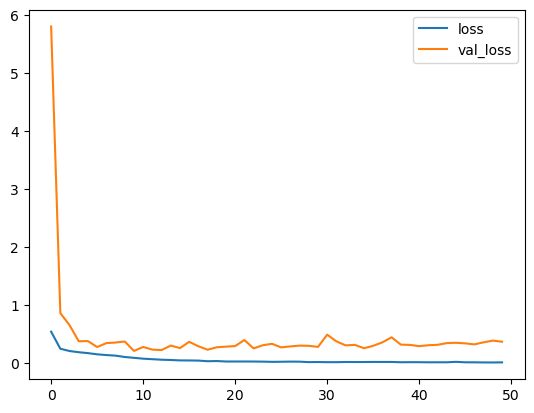

In [7]:
#Model fitting and training 
new_dataset = np.array(dataset)
X_train, X_test, y_train, y_test = train_test_split(new_dataset, to_categorical(np.array(labels)), test_size = 0.20, random_state = 0)
print(type(new_dataset))
print(type(to_categorical(np.array(labels))))
history = model.fit(x = X_train, y = y_train, batch_size = 64, epochs = 50, verbose = 1, validation_data = (X_test, y_test), shuffle = False)
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()

with open('/kaggle/working/file.pkl', 'wb') as f:
    pickle.dump(model, f)

In [10]:
import tensorflow as tf
tf.keras.models.save_model(model,'my_model.hdf5')